In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

NUM_CLASS = 2
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5

In [2]:
# Define paths to the train and test directories
train_dir = 'data2/train'
val_dir = 'data2/val'
test_dir = 'data2/test'

In [3]:
data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 5000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Model Training and Validation

In [4]:
# Define the model
inception_model = Sequential()
inception_model.add(InceptionV3(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
inception_model.add(Dense(NUM_CLASS, activation='softmax'))

# Freeze the base model
inception_model.layers[0].trainable = False

# Compile the model
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [5]:
# Train the model
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)//BATCH_SIZE,
    verbose=1
)

Epoch 1/5


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step - accuracy: 0.4531 - loss: 0.8439 - val_accuracy: 0.5800 - val_loss: 0.6334
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 69s 69s/step - accuracy: 0.5625 - loss: 0.6469 - val_accuracy: 0.7340 - val_loss: 0.5467
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 71s 71s/step - accuracy: 0.6875 - loss: 0.5652 - val_accuracy: 0.8440 - val_loss: 0.4716
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step - accuracy: 0.8125 - loss: 0.4778 - val_accuracy: 0.8920 - val_loss: 0.4007
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - accuracy: 0.8125 - loss: 0.4617 - val_accuracy: 0.9300 - val_loss: 0.3455


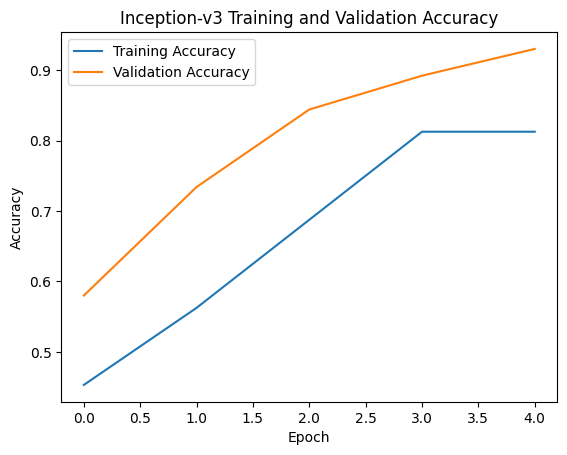

In [6]:
# Plot accuracy
plt.plot(inception_history.history['accuracy'], label='Training Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Inception-v3 Training and Validation Accuracy')
plt.legend()
plt.show()

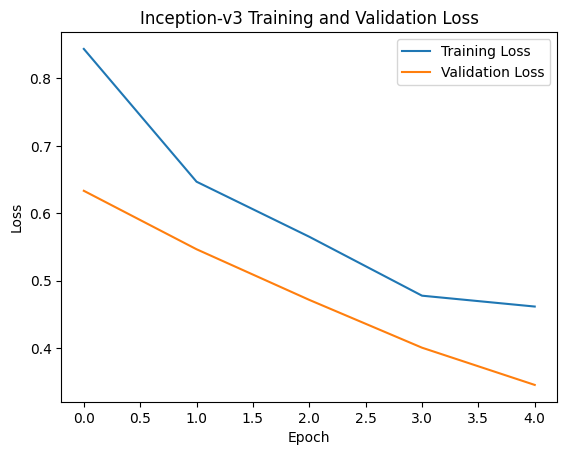

In [7]:
# Plot loss
plt.plot(inception_history.history['loss'], label='Training Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Inception-v3 Training and Validation Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 11s/step


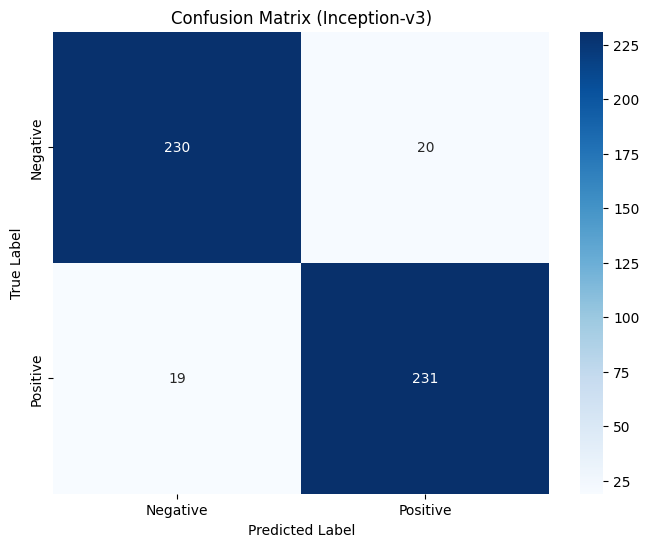

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict classes for test data
y_pred = inception_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes for test data
true_classes = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Inception-v3)')
plt.show()

In [9]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F1-score for each class
metrics_df = pd.DataFrame(report).transpose()

# Select relevant columns
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Display the DataFrame
print(metrics_df)


              precision  recall  f1-score
Negative       0.923695   0.920  0.921844
Positive       0.920319   0.924  0.922156
accuracy       0.922000   0.922  0.922000
macro avg      0.922007   0.922  0.922000
weighted avg   0.922007   0.922  0.922000


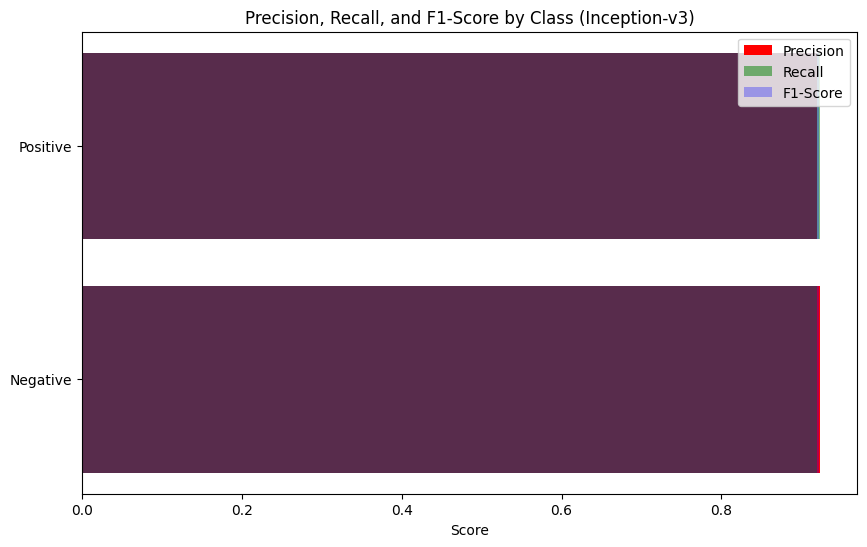

In [10]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and F-measure for each class
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

# Plot matrix diagram
plt.figure(figsize=(10, 6))
plt.barh(class_labels, precision, color='r', label='Precision')
plt.barh(class_labels, recall, color='g', label='Recall', alpha=0.5)
plt.barh(class_labels, f1_score, color='b', label='F1-Score', alpha=0.3)
plt.xlabel('Score')
plt.title('Precision, Recall, and F1-Score by Class (Inception-v3)')
plt.legend()
plt.show()
